In [114]:
from skimage.filters import threshold_otsu, gaussian
from skimage.restoration import denoise_wavelet
from PIL import Image, ImageStat
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy import ndimage
import os
from skimage.segmentation import morphological_chan_vese, checkerboard_level_set

In [115]:
def carbon_simplify(img):
    simplified = np.array([[np.clip((((pxl*3)//40)+1)*40,0,255)  if pxl != 0 else 0 
                            for pxl in row] for row in img])
    return simplified

In [116]:
def oil_simplify(img):
    simplified = np.array([[(pxl//40)*40 for pxl in row] for row in img])
    return simplified

In [120]:
def get_mask(img):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    pil_img = Image.fromarray(img_hsv)
    mean_hue, mean_sat, mean_val = ImageStat.Stat(pil_img).mean
    img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    dark = (0,0,5)
    light = (20,255,200)
    mask_orange = cv2.inRange(img_hsv, dark, light)
    img_orange = cv2.bitwise_and(img_gray, img_gray, mask=mask_orange)
    
    dark = (120,0,5)
    light = (180,255,60)
    mask_red = cv2.inRange(img_hsv, dark, light)
    img_red = cv2.bitwise_and(img_gray, img_gray, mask=mask_red)
    
    img_carbon = cv2.bitwise_or(img_orange, img_red)
    img_carbon = ndimage.median_filter(input=img_carbon, size=20, cval=0.0, mode='reflect') #1
    img_carbon = carbon_simplify(img_carbon)
    init_ls = checkerboard_level_set(img_carbon.shape, 6)
    ls_carbon = morphological_chan_vese(img_carbon, 35, init_level_set=init_ls, smoothing=3)
    
    dark = (0,0,50+mean_val/3)
    light = (179,255,255)
    mask_yel = cv2.inRange(img_hsv, dark, light)
    img_yel = cv2.bitwise_and(img_gray, img_gray, mask=mask_yel)
    img_yel = ndimage.median_filter(input=img_yel, size=20, cval=0.0, mode='reflect') #2
    img_yel = oil_simplify(img_yel)
    ls_yel = morphological_chan_vese(img_yel, 35, init_level_set=init_ls, smoothing=3)
    ls = np.concatenate((ls_carbon, ls_yel))
    
    mask = np.array([[[img_carbon[i][j], img_yel[i][j], 0] for j in range(len(img[0]))] for i in range(len(img))])
    return mask, ls

In [121]:
image = Image.open('data/Unload2/data/1001885.jpeg')
w, h = image.size
i = 5
max_reas = 0
pos = 0
while i <= w/4:
    area = [i, 0, i+1, h]
    leftcrop = image.crop(area)
    area = [i+1, 0, i+2, h]
    rightcrop = image.crop(area)
    lr, lg, lb = ImageStat.Stat(leftcrop).mean
    rr, rg, rb = ImageStat.Stat(rightcrop).mean
    reas = abs(rr-lr + rg-lg + rb-lb)
    if reas > 3:
        max_reas = reas
        pos = i
    i += 1
    
i = w-5
max_reas = 0
pos2 = w
while i >= w*3/4:
    area = [i, 0, i+1, h]
    leftcrop = image.crop(area)
    area = [i, 0, i+2, h]
    rightcrop = image.crop(area)
    lr, lg, lb = ImageStat.Stat(leftcrop).mean
    rr, rg, rb = ImageStat.Stat(rightcrop).mean
    reas = abs(rr-lr + rg-lg + rb-lb)
    if reas > 3:
        max_reas = reas
        pos2 = i
    i -= 1

croparea = [pos, 0, pos2, h]
cropped_img = np.array(image.crop(croparea))

In [122]:
mask, ls = get_mask(cropped_img)

Text(0.5, 1.0, 'Mask')

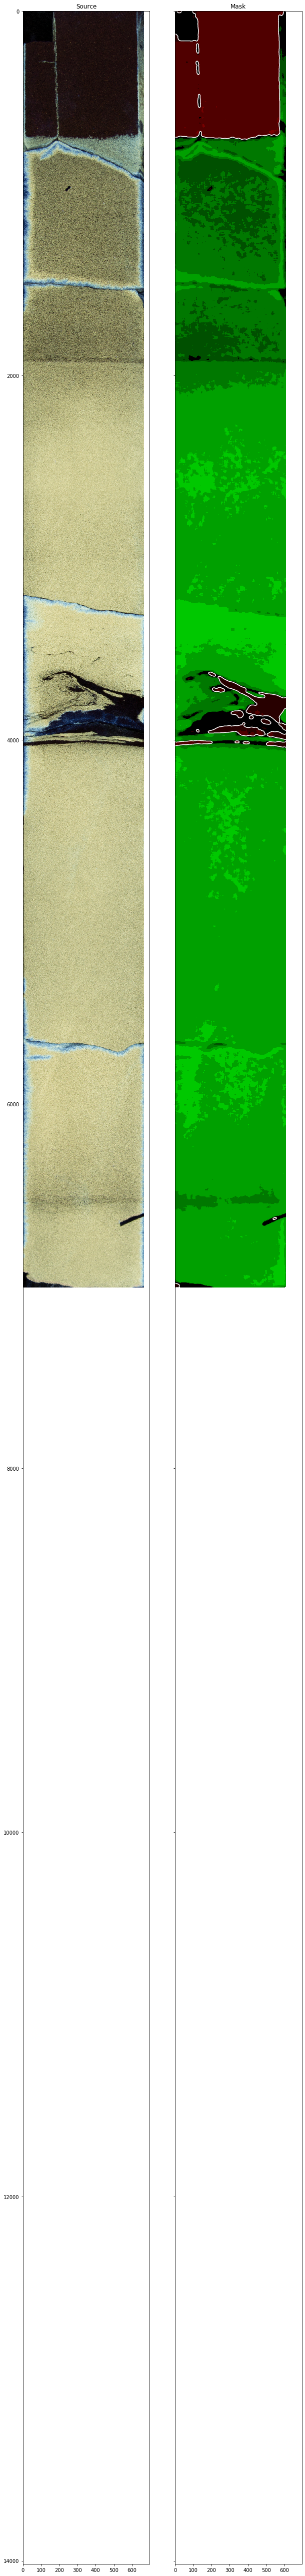

In [123]:
fig, (ax1,ax2) = plt.subplots(1, 2,  figsize=(10,100), sharex=True, sharey=True)

ax1.imshow(image)
ax1.set_title('Source')
ax2.imshow(mask)
ax2.contour(ls, [0.5], colors='w')
ax2.set_title('Mask')